# Imports

In [13]:
from PIL import Image

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
import dataset
from dataset import SiameseNetDataset

In [3]:
import utils
from utils import imshow, show_plot

In [4]:
import training
from training import train

## Showing samples

In [5]:
folder_dataset = datasets.ImageFolder(root="data/faces/training")

transformation = transforms.Compose([transforms.Resize((100, 100)),
                                    transforms.ToTensor()])

siamese_dataset = dataset.SiameseNetDataset(imgFolderDataset=folder_dataset,
                                            transform=transformation)

In [6]:
siamese_dataset.__len__()

370

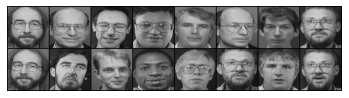

[0. 1. 1. 1. 1. 1. 1. 0.]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=8)

example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]), 0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

# Training model

In [12]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=2, batch_size=64)

In [15]:
counter, history = train(train_dataloader=train_dataloader, epochs=100)

Epoch number 0: current loss 2.434471607208252

Epoch number 1: current loss 0.9379298686981201

Epoch number 2: current loss 0.8854883909225464

Epoch number 3: current loss 0.822731614112854

Epoch number 4: current loss 0.7070943117141724

Epoch number 5: current loss 0.6478575468063354

Epoch number 6: current loss 0.4969000220298767

Epoch number 7: current loss 0.37176716327667236

Epoch number 8: current loss 0.700924277305603

Epoch number 9: current loss 0.6158021688461304

Epoch number 10: current loss 1.0492210388183594

Epoch number 11: current loss 0.6240783929824829

Epoch number 12: current loss 0.43267470598220825

Epoch number 13: current loss 0.7191181182861328

Epoch number 14: current loss 0.730285108089447

Epoch number 15: current loss 0.5229741930961609

Epoch number 16: current loss 0.5114505290985107

Epoch number 17: current loss 0.44129127264022827

Epoch number 18: current loss 0.5296761989593506

Epoch number 19: current loss 0.49247339367866516

Epoch numb

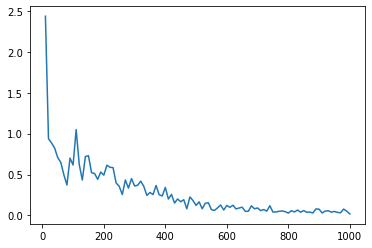

In [16]:
show_plot(counter, history)

# Testing the Model

In [8]:
folder_dataset_test = datasets.ImageFolder(root='data/faces/testing/')

siamese_dataset_test = SiameseNetDataset(imgFolderDataset=folder_dataset_test,
                                         transform=transformation)

test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

In [49]:
images = []
for i in range(siamese_dataset_test.__len__()):
    image, _, _ = siamese_dataset_test.__getitem__(i)
    images.append(image)

len(images)

30

In [9]:
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

In [10]:
model = torch.load('network.pth')
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

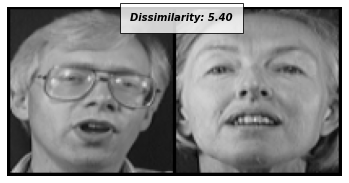

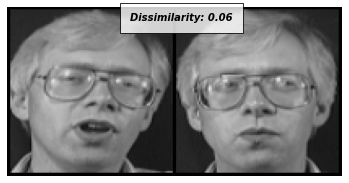

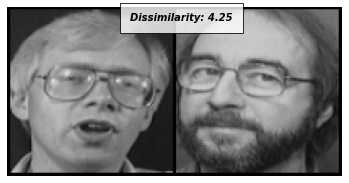

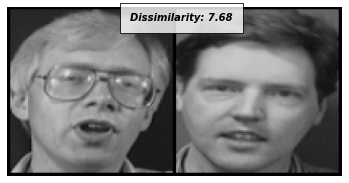

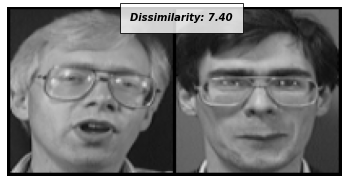

In [11]:
for i in range(5):
    _, x1, label2 = next(dataiter)
    
    concatenated = torch.cat((x0, x1), 0)
    
    out1, out2 = model(x0.cuda(), x1.cuda())
    euc_dist = F.pairwise_distance(out1, out2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euc_dist.item():.2f}')

In [20]:
myimage = Image.open('myimage.jpeg')
myimage.size

(460, 460)

In [23]:
img = myimage.convert('L')
img.size

(460, 460)

In [24]:
img = transformation(img)
img.size

<function Tensor.size>

In [25]:
img.shape

torch.Size([1, 100, 100])

In [26]:
x0.shape

torch.Size([1, 1, 100, 100])

In [27]:
img = img.reshape_as(x0)

In [28]:
img.shape

torch.Size([1, 1, 100, 100])

In [52]:
images[1].shape

torch.Size([1, 100, 100])

In [60]:
m = 2.0
for image in images:
    image = image.reshape_as(img)
    concatenated = torch.cat((img, image), 0)
    
    out1, out2 = model(img.cuda(), image.cuda())
    euc_dist = F.pairwise_distance(out1, out2)
   
    if euc_dist.item() < m:
        m = euc_dist.item()
        out = concatenated
    # if euc_dist.item() < 5.0:
    #     imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euc_dist.item():.2f}')